In [93]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [94]:
import dill
from IPython.core import display as ICD  # to print multiple nice pandas tables
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tqdm
import glob
from tqdm import tqdm_notebook, tnrange
sns.set()

In [95]:
import datasets
import classify
from simple_model import SimpleModel
from testing import test_simple_model
import utils

In [96]:
from collections import defaultdict


# Batch results

In [55]:
result_pattern = 'dumps_new/batch_results_{}.pickle'
dump_pattern = 'dumps_new/batch_dump_{}.pickle'
result_fnames = glob.glob(result_pattern.format('*'))
results = defaultdict(dict)
for fname in result_fnames:
    d = pickle.load(open(fname,'rb'))
    for k1 in d:
        for k2 in d[k1]:
            results[k1][k2] = d[k1][k2]
my_df = pd.DataFrame(results).loc['batch']

In [61]:
my_df_no_index = my_df.reset_index().drop(columns=['level_4'])
crossvalidated = my_df_no_index.groupby(['level_0','level_1', 'level_2','level_3'], as_index=True).mean()
crossvalidated.index.names = ['scheme', 'alpha', 'lsa', 'set']
crossvalidated = crossvalidated.swaplevel(0,1)

In [62]:
crossvalidated.to_hdf(key='default', path_or_buf='clean_dumps/batch_results.hdf')

## Load lsa results

In [63]:
lsa_df = pd.read_hdf('clean_dumps/baseline_results.hdf').loc[['lsa200','lsa300', 'lsa400']].rename(index={'lsa200':200, 'lsa300':300, 'lsa400':400})
lsa_df.index.names = ['lsa', 'scheme', 'set']
lsa_df = lsa_df.swaplevel(0,1)

In [64]:
# crossvalidated.index.levels[0]
diff = (crossvalidated.loc[0.01]-lsa_df)

In [76]:
test_dif = diff.loc[(slice(None),slice(None),'test'),:]

In [77]:
test_dif.round(2).style.applymap(utils.color_positives)

In [84]:
to_table = test_dif.reset_index(level='set').drop(columns='set')

In [104]:
def form(x):
    if x>0:
        return "\\textbf{{{}}}".format(x)
    else:
        return "{}".format(x)


In [119]:
latex = to_table[utils.NOTREC].round(2).to_latex(formatters=[form for _ in to_table.columns])
latex = utils.multireplace(latex, [
    ('\\textbackslash','\\'),
    ('  ',' '),
    ('Dataset',''),
    ('\\{','{'),
    ('\\}','}'),
    
])
print(utils.tabular(latex))


\begin{table}[H]
\begin{center}

\begin{tabular}{llrrrr}
\toprule
   &   &   CR &  MPQA &   MR &  SUBJ \\
scheme & lsa &        &        &        &        \\
\midrule
None & 200 & \textbf{0.02} &     -0.03 &     -0.01 & \textbf{0.02} \\
   & 300 & \textbf{0.04} &     -0.03 & \textbf{0.02} & \textbf{0.01} \\
   & 400 & \textbf{0.02} &     -0.02 & \textbf{0.02} & \textbf{0.01} \\
tfchi2 & 200 & \textbf{0.01} &     -0.01 &     -0.03 &     -0.02 \\
   & 300 &      0.0 &     -0.0 &     -0.03 &     -0.03 \\
   & 400 & \textbf{0.01} &     -0.0 &     -0.04 &     -0.04 \\
tfgr & 200 & \textbf{0.04} &     -0.01 &     -0.01 &     -0.02 \\
   & 300 &      0.0 &     -0.01 &     -0.01 &     -0.02 \\
   & 400 & \textbf{0.01} &     -0.0 &     -0.04 &     -0.03 \\
tfidf & 200 & \textbf{0.02} &     -0.02 & \textbf{0.03} & \textbf{0.03} \\
   & 300 & \textbf{0.02} &     -0.01 & \textbf{0.04} & \textbf{0.03} \\
   & 400 & \textbf{0.03} &     -0.01 & \textbf{0.04} & \textbf{0.03} \\
tfig & 200 & \textbf{0

In [122]:
latex = to_table[utils.TREC].round(2).to_latex(formatters=[form for _ in to_table.columns])
latex = utils.multireplace(latex, [
    ('\\textbackslash','\\'),
    ('  ',' '),
    ('TRECDataset-',''),
    ('\\{','{'),
    ('\\}','}'),
    
])
print(utils.tabular(latex))


\begin{table}[H]
\begin{center}

\begin{tabular}{llrrrrrr}
\toprule
   &   & ABBR & DESC & ENTY & HUM & LOC & NUM \\
scheme & lsa &         &         &         &         &         &         \\
\midrule
None & 200 &       0.0 &  \textbf{0.09} &  \textbf{0.02} &  \textbf{0.01} &  \textbf{0.01} &      -0.0 \\
   & 300 &       0.0 &  \textbf{0.07} &  \textbf{0.03} &      -0.0 &  \textbf{0.01} &       0.0 \\
   & 400 &       0.0 &  \textbf{0.08} &  \textbf{0.03} &       0.0 &  \textbf{0.02} &       0.0 \\
tfchi2 & 200 &       0.0 &  \textbf{0.04} &      -0.04 &      -0.01 &  \textbf{0.01} &      -0.02 \\
   & 300 &       0.0 &  \textbf{0.05} &      -0.04 &      -0.01 &  \textbf{0.01} &      -0.02 \\
   & 400 &  \textbf{0.01} &  \textbf{0.03} &      -0.04 &      -0.01 &       0.0 &      -0.02 \\
tfgr & 200 &       0.0 &  \textbf{0.05} &      -0.04 &      -0.01 &  \textbf{0.01} &      -0.01 \\
   & 300 &       -0.0 &  \textbf{0.06} &      -0.05 &      -0.01 &       0.0 &      -0.02 \\
   & 4

In [8]:
dump_pattern = 'dumps/batch_dump_{}.pickle'
dump_files = glob.glob(dump_pattern.format('*')) 

In [11]:
d = pickle.load(open(dump_files[0],'rb'))

# learning rate dependency

In [11]:
lines = defaultdict(list)
for dataset in my_df.columns:
    for scheme in my_df.index.levels[0]:
        for dim in my_df.index.levels[2]:
            for alpha in my_df.index.levels[1]:
                lines[(dataset, scheme, dim)].append(my_df.loc[(scheme, alpha, dim, 'test'), dataset])
    

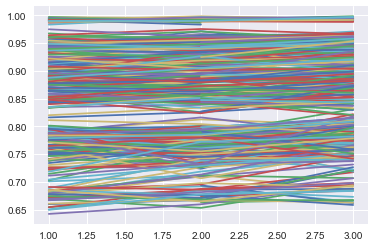

In [12]:
for k in lines:
    plt.plot([1,2,3],lines[k])

In [29]:
my_df.index.levels[1]

Float64Index([0.001, 0.01, 0.1], dtype='float64')

In [14]:
no_index = my_df.reset_index()
no_index = no_index[no_index['level_3']=='test']

In [15]:
no_index = no_index[['level_0','level_2','level_1']+my_df.columns.tolist()]

In [16]:
no_index = no_index.sort_values(['level_0','level_2','level_1'], ascending=True)
pivoted = pd.pivot_table(no_index, index = 'level_1', columns = ['level_0','level_2'], values=my_df.columns.tolist())

In [17]:
cm = sns.light_palette("green", as_cmap=True)
pivoted.style.background_gradient(cmap=cm)

/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)
